# Thick Sample Ptychography Forward Model Tutorial 2D Parallel In Time Solves

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [1]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEFullPinTSolver, PWEPetscFullPinTSolver
from matplotlib import pyplot as plt
import time

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [2]:
probe_config = ProbeConfig(
    type=ProbeType.AIRY_DISK,
    wave_length=0.635e-6,  # meters (0.635 μm). Visible light
    diameter=10e-6,  # [m]
    focus=-3e-6,  # focal length [m]
    # tilts=(np.linspace(-15,15,3)) # tilts in degrees
)

### Discretization Parameters and Spatial Limits

In [3]:
# Width Discretization (Pixels)
scan_points = 1
step_size_px = 20 * 50
pad_factor = 2.0  # Must be >= 1.0
# Overlap = N - (scan_points*step_size_px) = padding
# Overlap factor = (N - (scan_points*step_size_px)) / step_size_px
#                = (pad_factor*scan_points) - scan_points) = scan_points*(pad_factor - 1)
# N = int(pad_factor*scan_points*step_size_px)
solve_reduced_domain = False

# Thickness Discretization (Pixels)
points_per_wavelength = 8
# Then:
#  - dz = wavelength / points_per_wavelength
#  - nz = int((zlims[1] - zlims[0]) / dz)
# Override by setting nz directly


# --- Simulation spatial dimensions (in meters) ---
spatial_limits = Limits(
    x=(0.0, 150e-6),  # Sample width
    z=(0.0, 40e-6),  # Sample thickness
    units="meters",
)

2025-12-10 18:27:08,974 - INFO - === Scan Summary ===
2025-12-10 18:27:08,979 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-10 18:27:08,982 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-10 18:27:08,993 - INFO -   Sample Pixels:          2001 px
2025-12-10 18:27:08,996 - INFO -   Step size:              1000 px
2025-12-10 18:27:08,999 - INFO -   Number of scan points:  1
2025-12-10 18:27:09,002 - INFO -   Steps in z:             503
2025-12-10 18:27:09,013 - INFO -   Probe diameter:         1.000e-05 m
2025-12-10 18:27:09,016 - INFO -   Probe Pixels:           133 px


Padding/Overlap: 1001


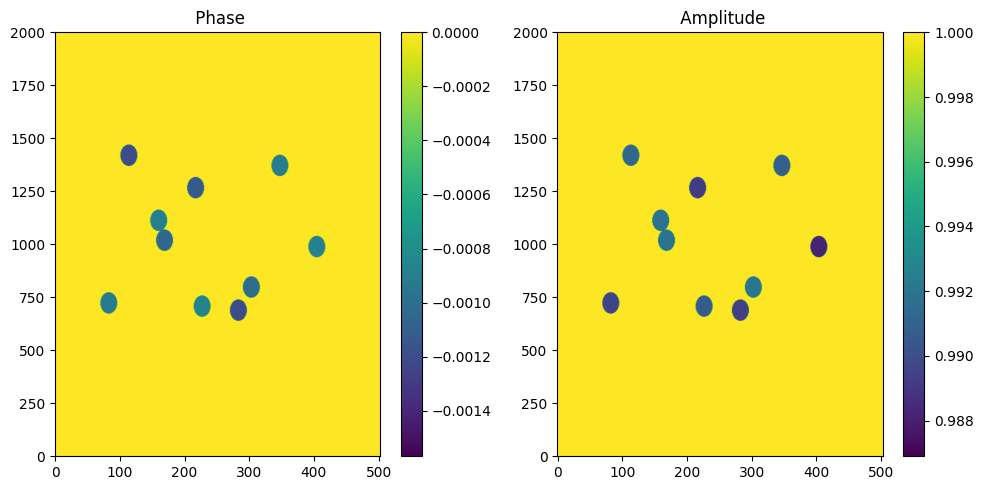

In [4]:
# --- Create the SimulationConfig object ---
# Defines scan path, probe parameters, discretization,
# object domain.
# Solver parameters are defined in the solver classes.
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=scan_points,
    step_size_px=step_size_px,
    pad_factor=pad_factor,
    solve_reduced_domain=False,
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=1.0,  # 1.0 for free space
    # Logging and results
    results_dir="./results",
    use_logging=True,
)

# --- Create the simulation space ---
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()
print("Padding/Overlap:", simulation_space.nx - simulation_space.min_nx)

# --- Create a Simultated Ptycho Object ---
ptycho_object = create_ptycho_object(simulation_space)

# # Base refractive index offsets
delta = 0.01
beta = 0.001

# Variation strength (fractional)
delta_var = 0.20  # ±20% variation in phase shift
beta_var = 0.20  # ±20% variation in absorption

gaussian_blur = 0.5
common_side_length = 0.05
common_depth = 0.05
num_circles = 10
random_seed = 5

np.random.seed(random_seed)

# Generate random (x,z) centers
x_centers = np.random.uniform(0.25, 0.75, size=num_circles)
z_centers = np.random.uniform(0.1, 0.9, size=num_circles)

for cx, cz in zip(x_centers, z_centers):
    # Randomize refractive index perturbation per circle
    delta_rand = delta * (1 + delta_var * (np.random.rand() - 0.5) * 2)
    beta_rand = beta * (1 + beta_var * (np.random.rand() - 0.5) * 2)

    refractive_index_perturbation = -delta_rand - 1j * beta_rand

    ptycho_object.add_object(
        "circle",
        refractive_index_perturbation,
        side_length_factor=common_side_length,
        centre_factor=(cx, cz),
        depth_factor=common_depth,
        gaussian_blur=gaussian_blur,
    )
ptycho_object.build_field()
# delta = 0.01
# beta = 0.001
# ptycho_object.load_image("/home/dnz75396/thick_ptycho/notebooks/UKRI.tiff",
#                          real_perturbation=delta, imaginary_perturbation=beta)
simulation_space.viewer.plot_two_panels(
    ptycho_object.refractive_index, view="phase_amp"
)


# --- Create a set of Simulated Ptycho Probes ---
ptycho_probes = create_ptycho_probes(simulation_space)

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [5]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_full = PWEFullPinTSolver(
    simulation_space, ptycho_probes, alpha=1e-6, atol=1e-5, verbose=True
)

# Iterative solution
u_pwe_full = forward_model_pwe_full.solve()
time_end = time.time()
solve_time_scipy = time_end - time_start
print(f"Forward model creation and solving time: {solve_time_scipy:.2f} seconds.\n")
exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(
    exit_waves=exit_waves_pwe_full, poisson_noise=True
)
intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(
    exit_waves=exit_waves_pwe_full, poisson_noise=False
)

Forward model creation and solving time: 21.39 seconds.



/home/dnz75396/miniconda3/envs/petsc_proj/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dnz75396/miniconda3/envs/petsc_proj/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


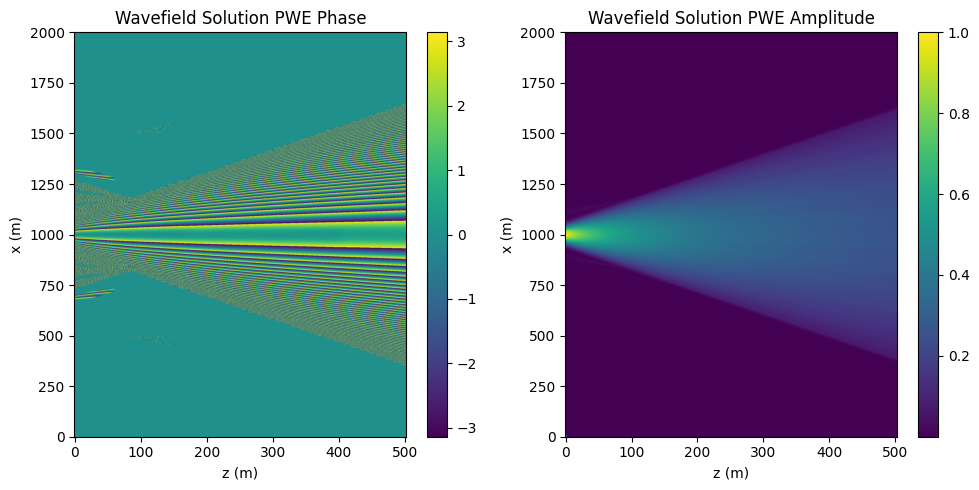

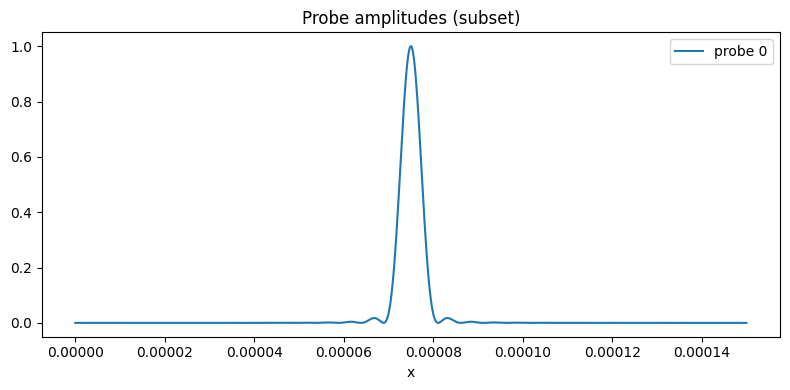

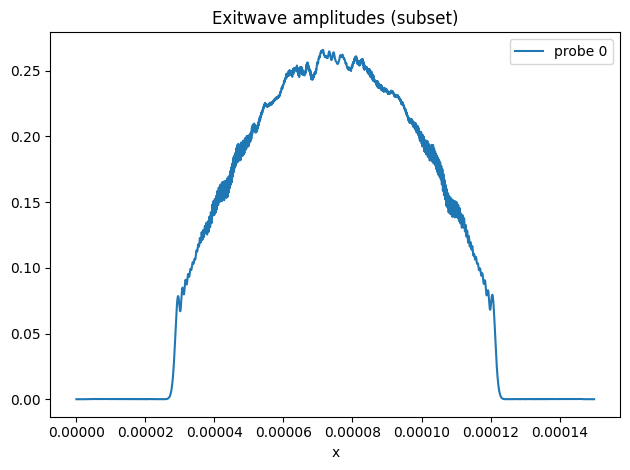

In [6]:
# Select Centre Probe
centre_probe_pwe = u_pwe_full[0, 0, simulation_space.num_probes // 2, ...]
simulation_space.viewer.plot_two_panels(
    centre_probe_pwe,
    view="phase_amp",
    title="Wavefield Solution PWE",
    xlabel="z (m)",
    ylabel="x (m)",
)

plt.plot(simulation_space.x, centre_probe_pwe[:, simulation_space.nz // 2])
plt.show()

plt.figure(figsize=(8, 4))
p = 0
plt.plot(simulation_space.x, np.abs(u_pwe_full[0, 0, p, :, 0]), label=f"probe {p}")
plt.title("Probe amplitudes (subset)")
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(simulation_space.x, np.abs(u_pwe_full[0, 0, p, :, -1]), label=f"probe {p}")
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_full = PWEPetscFullPinTSolver(
    simulation_space, ptycho_probes, alpha=1e-6, atol=1e-5, verbose=True
)

# Iterative solution
u_pwe_full = forward_model_pwe_full.solve()
time_end = time.time()
solve_time_petsc = time_end - time_start
print(f"Forward model creation and solving time: {solve_time_petsc:.2f} seconds.\n")
exit_waves_pwe_full = forward_model_pwe_full.get_exit_waves(u_pwe_full)
intensities_pwe_noisy_full = forward_model_pwe_full.get_farfield_intensities(
    exit_waves=exit_waves_pwe_full, poisson_noise=True
)
intensities_pwe_full = forward_model_pwe_full.get_farfield_intensities(
    exit_waves=exit_waves_pwe_full, poisson_noise=False
)

print(
    f"Petsc solver was {solve_time_scipy / solve_time_petsc:.2f} times the speed of the Scipy solver."
)

Forward model creation and solving time: 2.73 seconds.

Petsc solver was 7.82 times the speed of the Scipy solver.


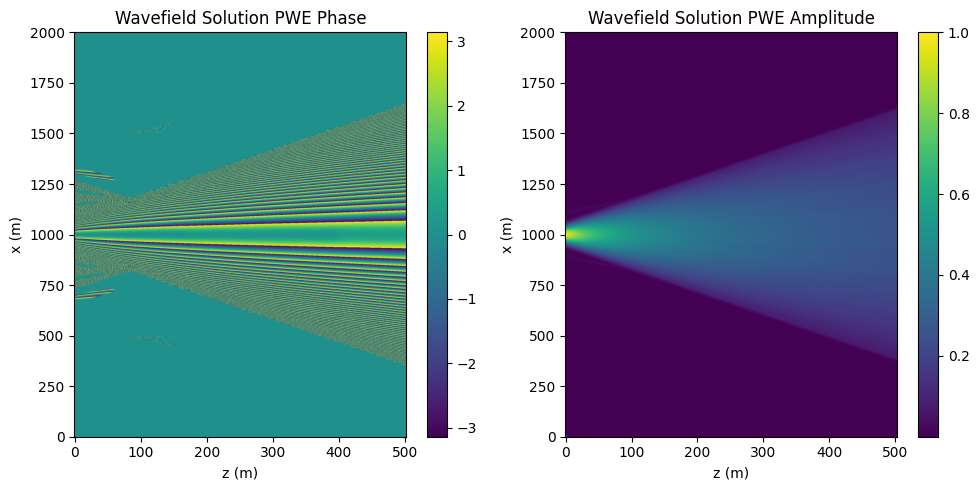

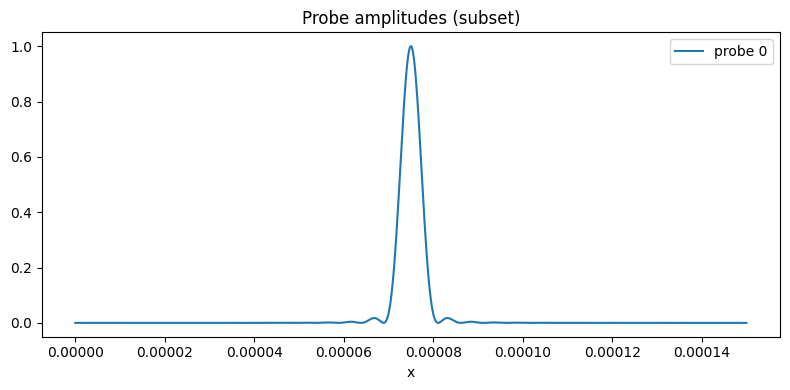

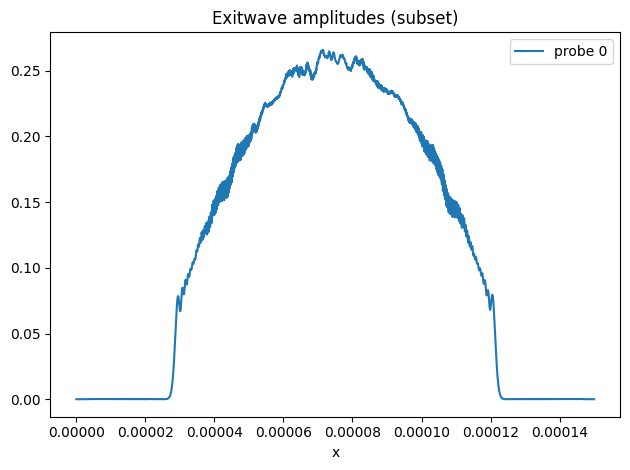

In [8]:
# Select Centre Probe
centre_probe_pwe = u_pwe_full[0, 0, simulation_space.num_probes // 2, ...]
simulation_space.viewer.plot_two_panels(
    centre_probe_pwe,
    view="phase_amp",
    title="Wavefield Solution PWE",
    xlabel="z (m)",
    ylabel="x (m)",
)

plt.plot(simulation_space.x, centre_probe_pwe[:, simulation_space.nz // 2])
plt.show()

plt.figure(figsize=(8, 4))
p = 0
plt.plot(simulation_space.x, np.abs(u_pwe_full[0, 0, p, :, 0]), label=f"probe {p}")
plt.title("Probe amplitudes (subset)")
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.show()


plt.plot(simulation_space.x, np.abs(u_pwe_full[0, 0, p, :, -1]), label=f"probe {p}")
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x")
plt.legend()
plt.tight_layout()
plt.show()